In [170]:
#Import Turing, Distributionsm LinearAlgebra and DataFrames
using Turing, Distributions, LinearAlgebra, DataFrames

# Import MCMCChain, Plots, StatsPlots, GraphPlot, GraphRecipes and PyCall for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots, GraphPlot, GraphRecipes, PyCall, Statistics

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/RZOZ8/src/Turing.jl:24


false

In [54]:
# Set hyperparameters- K is the number of clusters and eta is the probability matrix between clusters 
K = 8
alpha = 0.1 * ones(K)
eta = Symmetric(rand(K,K))
# eta[diagind(eta)] .= 1
eta

8×8 Symmetric{Float64,Array{Float64,2}}:
 0.385365  0.184433   0.631061   0.880336  …  0.78526   0.649648   0.867332
 0.184433  0.227902   0.600094   0.625325     0.431152  0.513193   0.116806
 0.631061  0.600094   0.324801   0.403021     0.971246  0.0815799  0.625738
 0.880336  0.625325   0.403021   0.484802     0.447629  0.778573   0.471709
 0.799179  0.0901276  0.9306     0.553565     0.855724  0.321005   0.162612
 0.78526   0.431152   0.971246   0.447629  …  0.35718   0.575567   0.699057
 0.649648  0.513193   0.0815799  0.778573     0.575567  0.670643   0.355112
 0.867332  0.116806   0.625738   0.471709     0.699057  0.355112   0.474177

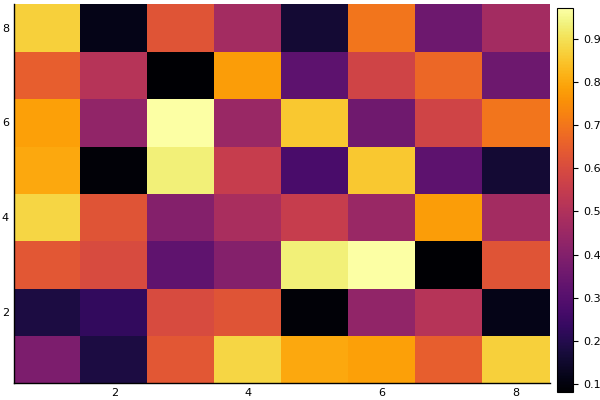

In [55]:
# Generate data using randomly generated cluster assignments
N = 20
clusters = rand(1:K, N)
graph = zeros(N,N)
for i=1:N
    graph[i, i] = 1
    for j = 1:i-1
        cluster_i = clusters[i]
        cluster_j = clusters[j]
        eta_ij = eta[cluster_i, cluster_j]
        if(eta_ij > rand())
            graph[i, j] = 1
            graph[j, i] = 1
        end
    end
end
pyplot()
heatmap(graph)

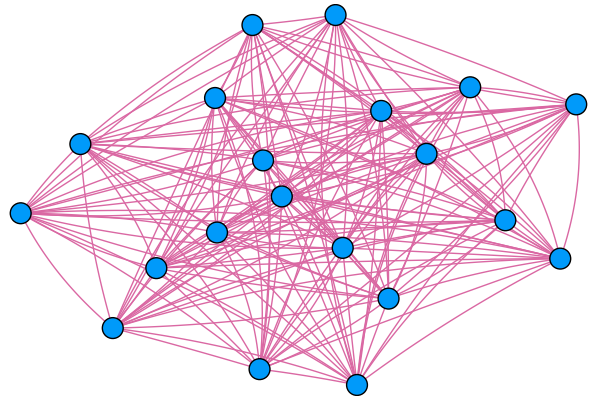

In [60]:
graphplot(graph)

In [61]:
# Define the model
@model mmsb(alpha, eta, graph, N) = begin
    pi = Vector{Vector}(undef, N)
    for n=1:N
        pi[n] ~ Dirichlet(alpha)
    end
    
    for n=1:N
        for m=1:n-1
            z_nm ~ Categorical(pi[n])
            z_mn ~ Categorical(pi[m])
            graph[n, m] ~ Bernoulli(eta[z_nm, z_mn])
        end
    end
end;

In [64]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using HMC
# chains = mapreduce(c -> sample(poisson_regression(data, data_labels, n, 10), NUTS(2500, 200, 0.65) ), chainscat, 1:num_chains);
g = Gibbs(1000, HMC(2, 0.001, 7, :pi), PG(20, 1, :z_nm, :z_mn))
chain = sample(mmsb(alpha, eta, graph, N), g)

┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:185
┌ Info:   Running time    = 3837.931210559004;
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:186


Object of type Chains, with data of type 1000×167×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
internals         = elapsed, epsilon, eval_num, lf_num, lp
parameters        = pi[5][2], pi[18][4], pi[18][6], pi[7][5], pi[6][1], pi[19][3], pi[16][2], pi[16][4], pi[9][6], pi[12][6], pi[12][2], pi[3][2], z_mn, pi[12][4], pi[11][4], pi[19][8], pi[16][6], pi[2][5], pi[15][4], pi[13][8], pi[10][8], pi[12][7], pi[7][1], pi[13][6], pi[14][7], pi[1][7], pi[8][8], pi[9][3], pi[10][2], pi[4][2], pi[8][7], pi[9][5], pi[18][8], pi[4][8], pi[16][1], pi[17][6], pi[11][2], pi[13][1], pi[1][6], pi[17][8], pi[14][6], pi[7][2], pi[2][3], pi[6][6], pi[17][3], pi[20][5], pi[10][3], pi[3][1], pi[19][5], pi[10][5], pi[2][8], pi[7][4], pi[10][7], pi[5][1], pi[19][4], pi[13][5], pi[20][3], pi[16][8], pi[5][6], pi[8][6], pi[15][1], pi[13][3], pi[13][4], pi[6][2], pi[20][8], pi[4][1], pi[8][3], pi[3][7], 

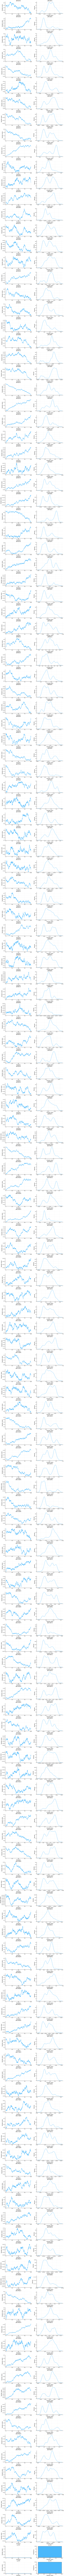

In [65]:
plot(chain)

In [191]:
# Find the predicted clusters using the new parameters
clusters_pred = Array{Int64}(undef, N)
df = DataFrame(chain[:pi])
means = colwise(mean, df)
count = 1
i = 1

#Finding the index of the max value in each interval of size K (which represents the probabilities for each node) to get the predicted cluster assignments
max = means[1]
for mean in means
    if(mean >= max)
        clusters_pred[i] = count
        max = mean
    end
    count += 1
    if(count == K + 1)
        count = 1
        max = -Inf
        i += 1
    end
end
clusters_pred

┌ Warning: `colwise(f, d::AbstractDataFrame)` is deprecated, use `[f(col) for col = eachcol(d)]` instead.
│   caller = top-level scope at In[191]:11
└ @ Core In[191]:11


20-element Array{Int64,1}:
 2
 1
 3
 1
 1
 2
 2
 2
 2
 1
 2
 1
 1
 1
 1
 2
 1
 2
 2
 2

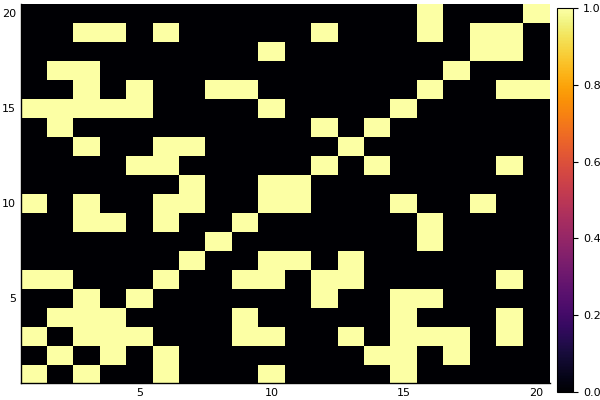

In [203]:
#Reconstructing the predicted graph using predicted cluster assignments
clusters
graph_pred = zeros(N,N)
for i=1:N
    graph_pred[i, i] = 1
    for j = 1:i-1
        cluster_i = clusters_pred[i] 
        cluster_j = clusters_pred[j]
        eta_ij = eta[cluster_i, cluster_j]
        if(eta_ij > rand())
            graph_pred[i, j] = 1
            graph_pred[j, i] = 1
        end
    end
end
heatmap(graph_pred)

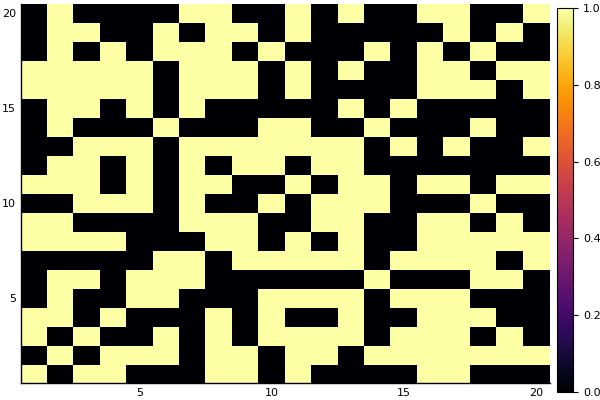

In [201]:
heatmap(graph)